In [1160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import plotnine as gg
from pathlib import Path
import glob
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Get patien ID, Run ID and Flowcell data

In [766]:
patient_id_data=pd.read_csv('/ghsfa/screening/analysis/2021-11-18_sandbox2_QC/joint_calls_annotated.full_sb2.tsv',sep="\t")
patient_id_data.to_csv('joint_calls_annotated.full_sb2.tsv')
run_id_data=pd.read_csv('/ghsfa/screening/analysis/2021-11-18_sandbox2_QC/qsymsre_metadata_latest.tsv',sep="\t")
run_id_data.to_csv('qsymsre_metadata_latest.tsv.tsv')
merge_patient_run_id_data = patient_id_data.merge(run_id_data, on=['patient_id'], suffixes=('_y', ''))
merge_patient_run_id_data.to_csv('merge_patient_run_id_data.tsv')

# BIP3 data

In [562]:
df_data = pd.read_csv('/ghsfa/screening/analysis/2021-11-18_sandbox2_QC/data.csv')
df_data.to_csv('data.tsv')
sandbox2_data = pd.merge(merge_patient_run_id_data, df_data, left_on=['run_id'], right_on=['run_sample_id'], how='inner', suffixes=('_y', ''))
sandbox2_data.to_csv('sandbox2_BIP3_data.tsv')

# BIP4 data

In [ ]:
import numpy as np
import os
import pandas as pd
import json
from pathlib import Path
from typing import List, Optional, Iterable, Tuple

def load_auto_qc_json(filename: str, categories: Optional[Iterable[str]] = None,
                           sample_ids: Optional[Iterable[str]] = None) -> pd.DataFrame:
        """
        Loads a BIP auto_qc file
        Args:
            filename,   A valid path to an auto_qc tsv file (distinct from auto_qc json file)
            categories, The set of categories to be loaded from the file ('flowcell', 'sample').
                        If set to None all types will be loaded
            sample_ids, A list of run_sample_ids to retain in the outputs.
                        If set to None then all samples will be loaded.
        Returns:
            data,       A dataframe containing the auto_qc file information.
        """
        with open(filename, "r") as file:
            autoqc = json.load(file)

        if categories is None:
            categories = ["sample", "flowcell"]

        runid = autoqc["run_id"]

        if "flowcell" in categories:
            flowcell_metrics = pd.DataFrame(autoqc["flowcell"]["metrics"])
            flowcell_metrics["runid"] = runid

            status_bool = autoqc["flowcell"]["pass"]
            if status_bool:
                status = "PASS"
            else:
                status = "FAIL"
            fc_pass_fail = pd.DataFrame({"metric": ["flowcell_pass_fail"],
                                         "verbose_name": ["Passing flowcell AutoQC tests"],
                                         "status": [status],
                                         "status_bool": [status_bool],
                                         "runid": [runid]})
            flowcell_metrics = flowcell_metrics.append(fc_pass_fail)
            flowcell_metrics["category"] = "flowcell"
        else:
            flowcell_metrics = pd.DataFrame()

        if "sample" in categories:
            sample_dicts = autoqc["samples"]
            sample_df_list = []
            for sample in sample_dicts:
                status_bool = sample_dicts[sample]["pass"]
                if status_bool:
                    status = "PASS"
                else:
                    status = "FAIL"
                sample_pass_fail = pd.DataFrame({"metric": ["sample_pass_fail"],
                                                 "verbose_name": ["Passing sample AutoQC tests"],
                                                 "status": [status],
                                                 "status_bool": [status_bool],
                                                 "run_sample_id": [sample],
                                                 "runid": [runid]})

                sample_df = pd.DataFrame(sample_dicts[sample]["metrics"])
                sample_df["runid"] = runid
                sample_df["run_sample_id"] = sample
                sample_df = sample_df.append(sample_pass_fail)
                sample_df_list.append(sample_df)

            sample_metrics = pd.concat(sample_df_list)
            sample_metrics["category"] = "sample"

            if sample_ids is not None:
                sample_metrics = sample_metrics.loc[sample_metrics.run_sample_id.isin(sample_ids)]
        else:
            sample_metrics = pd.DataFrame()

        autoqc_df = flowcell_metrics.append(sample_metrics)
        autoqc_df.value = autoqc_df.value.astype(float, errors='raise')
        autoqc_df.threshold = autoqc_df.threshold.astype(float, errors='raise')

        return autoqc_df[["runid", "run_sample_id", "category", "metric", "verbose_name",
                          "unit", "value", "operator", "threshold", "status", "decimal_places"]]
    
autoqc_df1 = load_auto_qc_json("/ghess/screening/data/studies/SANDBOX2_ECLIPSE2/BIP4/211029_A01194_0158_AHNH22DSX2.set6.211101_124653/autoqc_report.json")
autoqc_df2 = load_auto_qc_json("/ghess/screening/data/studies/SANDBOX2_ECLIPSE2/BIP4/211103_A01194_0160_AHNHY7DSX2.211105_160545/autoqc_report.json")
autoqc_df3 = load_auto_qc_json("/ghess/screening/data/studies/SANDBOX2_ECLIPSE2/BIP4/211105_A01021_0369_AH2GWJDSX3.211109_112811/autoqc_report.json")
autoqc_df4 = load_auto_qc_json("/ghess/screening/data/studies/SANDBOX2_ECLIPSE2/BIP4/211110_A01021_0371_AH2HGYDSX3.211112_170411/autoqc_report.json")
autoqc_df5 = load_auto_qc_json("/ghess/screening/data/studies/SANDBOX2_ECLIPSE2/BIP4/211112_A01021_0373_AH2HH2DSX3.211116_215252/autoqc_report.json")
print(len(autoqc_df1))
print(len(autoqc_df2))
autoqc_df=pd.concat([autoqc_df1,autoqc_df2,autoqc_df3,autoqc_df4,autoqc_df5],ignore_index=True)
print(len(autoqc_df))
autoqc_df.to_csv('autoqc_df.tsv')

32601
32624
158423


In [854]:
pass_fail = autoqc_df.dropna(axis=0, subset=["status"])
pass_fail[pass_fail['metric'] == 'sample_pass_fail']

,runid,run_sample_id,category,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
183,211029_A01194_0158_AHNH22DSX2,FB08876614,sample,sample_pass_fail,Passing sample AutoQC tests,NaN,NaN,NaN,NaN,PASS,NaN
355,211029_A01194_0158_AHNH22DSX2,FB08876267,sample,sample_pass_fail,Passing sample AutoQC tests,NaN,NaN,NaN,NaN,PASS,NaN
526,211029_A01194_0158_AHNH22DSX2,FB08876150,sample,sample_pass_fail,Passing sample AutoQC tests,NaN,NaN,NaN,NaN,FAIL,NaN
697,211029_A01194_0158_AHNH22DSX2,FB08876135,sample,sample_pass_fail,Passing sample AutoQC tests,NaN,NaN,NaN,NaN,PASS,NaN
869,211029_A01194_0158_AHNH22DSX2,FB08876202,sample,sample_pass_fail,Passing sample AutoQC tests,NaN,NaN,NaN,NaN,PASS,NaN
...,...,...,...,...,...,...,...,...,...,...,...
157901,211112_A01021_0373_AH2HH2DSX3,B173999,sample,sample_pass_fail,Passing sample AutoQC tests,NaN,NaN,NaN,NaN,FAIL,NaN
158072,211112_A01021_0373_AH2HH2DSX3,B174000,sample,sample_pass_fail,Passing sample AutoQC tests,NaN,NaN,NaN,NaN,FAIL,NaN
158243,211112_A01021_0373_AH2HH2DSX3,B174001,sample,sample_pass_fail,Passing sample AutoQC tests,NaN,NaN,NaN,NaN,FAIL,NaN
158419,211112_A01021_0373_AH2HH2DSX3,LTO319SC,sample,sample_pass_fail,Passing sample AutoQC tests,NaN,NaN,NaN,NaN,PASS,NaN


In [858]:
def get_sample_qc_status():
    df_sample = pass_fail[pass_fail['run_sample_id'] == 'B174001']
    df_sample_metrics = df_sample[df_sample['metric'] != 'sample_pass_fail']
    qc_fail = any(df_sample_metrics['status'] == 'FAIL')
    return qc_fail

True

In [860]:
df_metrics = pass_fail[pass_fail['metric'] != 'sample_pass_fail'].copy()
df_metrics.groupby('run_sample_id').apply(lambda x: any(x['status'] == 'FAIL'))

run_sample_id
B173978       False
B173979       False
B173980       False
B173981        True
B173982        True
              ...  
LTO319PP04     True
LTO319PP05     True
LTO319SC      False
LTO332_NTC    False
LTO332_SC     False
Length: 933, dtype: bool

In [861]:
pass_fail[pass_fail['metric'] == 'sample_pass_fail']

,runid,run_sample_id,category,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
183,211029_A01194_0158_AHNH22DSX2,FB08876614,sample,sample_pass_fail,Passing sample AutoQC tests,NaN,NaN,NaN,NaN,PASS,NaN
355,211029_A01194_0158_AHNH22DSX2,FB08876267,sample,sample_pass_fail,Passing sample AutoQC tests,NaN,NaN,NaN,NaN,PASS,NaN
526,211029_A01194_0158_AHNH22DSX2,FB08876150,sample,sample_pass_fail,Passing sample AutoQC tests,NaN,NaN,NaN,NaN,FAIL,NaN
697,211029_A01194_0158_AHNH22DSX2,FB08876135,sample,sample_pass_fail,Passing sample AutoQC tests,NaN,NaN,NaN,NaN,PASS,NaN
869,211029_A01194_0158_AHNH22DSX2,FB08876202,sample,sample_pass_fail,Passing sample AutoQC tests,NaN,NaN,NaN,NaN,PASS,NaN
...,...,...,...,...,...,...,...,...,...,...,...
157901,211112_A01021_0373_AH2HH2DSX3,B173999,sample,sample_pass_fail,Passing sample AutoQC tests,NaN,NaN,NaN,NaN,FAIL,NaN
158072,211112_A01021_0373_AH2HH2DSX3,B174000,sample,sample_pass_fail,Passing sample AutoQC tests,NaN,NaN,NaN,NaN,FAIL,NaN
158243,211112_A01021_0373_AH2HH2DSX3,B174001,sample,sample_pass_fail,Passing sample AutoQC tests,NaN,NaN,NaN,NaN,FAIL,NaN
158419,211112_A01021_0373_AH2HH2DSX3,LTO319SC,sample,sample_pass_fail,Passing sample AutoQC tests,NaN,NaN,NaN,NaN,PASS,NaN


In [565]:
sample = pass_fail[pass_fail['category'] == 'sample']
sample.head()
#autoqc_df.head()

,runid,run_sample_id,category,metric,verbose_name,unit,value,operator,threshold,status,decimal_places
14,211029_A01194_0158_AHNH22DSX2,FB08876614,sample,median_molecule_length,Median Molecule Length,bases,170.00000,<=,350.0,PASS,0.0
16,211029_A01194_0158_AHNH22DSX2,FB08876614,sample,sample_germline_contamination,Germline contamination,genes,0.00000,<=,10.0,PASS,0.0
17,211029_A01194_0158_AHNH22DSX2,FB08876614,sample,sample_contamination_pct,Family contamination,%,0.01621,<=,0.5,PASS,5.0
18,211029_A01194_0158_AHNH22DSX2,FB08876614,sample,sample_private_germline_contam,Private germline contamination,,0.00000,==,0.0,PASS,0.0
22,211029_A01194_0158_AHNH22DSX2,FB08876614,sample,sample_female_chry_molecules,Female chrY contamination,mols,0.00000,<=,44.0,PASS,0.0


# Process autoqc_table

In [768]:
autoqc_df_wide_table = autoqc_df.pivot_table('value', ['runid', 'run_sample_id'], 'metric')
autoqc_df_wide_table.to_csv('autoqc_df_wide_table.tsv')
autoqc_df_wide_table.head()

metric                                       hyper_genomic_avg_family_size  \
runid                         run_sample_id                                  
211029_A01194_0158_AHNH22DSX2 B173978                              37.1577   
                              B173979                              28.6169   
                              B173980                              31.4207   
                              B173981                              31.3315   
                              B173982                              29.7588   

metric                                       hyper_genomic_diversity  \
runid                         run_sample_id                            
211029_A01194_0158_AHNH22DSX2 B173978                            5.0   
                              B173979                            6.0   
                              B173980                            3.0   
                              B173981                            1.0   
                              B173982                            2.0   

metric                                       hyper_genomic_gc_absbias_molecules  \
runid                         run_sample_id                                       
211029_A01194_0158_AHNH22DSX2 B173978                                   0.05047   
                              B173979                                   0.15062   
                              B173980                                   0.03811   
                              B173981                                   0.14399   
                              B173982                                   0.07417   

metric                                       hyper_genomic_gc_absbias_reads  \
runid                         run_sample_id                                   
211029_A01194_0158_AHNH22DSX2 B173978                               0.06697   
                              B173979                               0.15406   
                              B173980                               0.07389   
                              B173981                               0.19270   
                              B173982                               0.12285   

metric                                       hyper_genomic_gc_high_0.79_molecules  \
runid                         run_sample_id                                         
211029_A01194_0158_AHNH22DSX2 B173978                                     0.00002   
                              B173979                                     0.00008   
                              B173980                                     0.00000   
                              B173981                                     0.00027   
                              B173982                                     0.00011   

metric                                       hyper_genomic_gc_high_0.79_reads  \
runid                         run_sample_id                                     
211029_A01194_0158_AHNH22DSX2 B173978                                 0.00000   
                              B173979                                 0.00000   
                              B173980                                 0.00000   
                              B173981                                 0.00001   
                              B173982                                 0.00003   

metric                                       hyper_genomic_gc_high_0.7_molecules  \
runid                         run_sample_id                                        
211029_A01194_0158_AHNH22DSX2 B173978                                    0.10513   
                              B173979                                    0.07650   
                              B173980                                    0.11152   
                              B173981                                    0.14179   
                              B173982                                    0.12179   

metric                                       hyper_genomic_

In [1161]:
sandbox2_data = pd.merge(merge_patient_run_id_data, autoqc_df_wide_table, left_on=['run_id'], right_on=['run_sample_id'], how='inner', suffixes=('_y', ''))
sandbox2_data.head()

,patient_id,Call_CEA+IL6,Call_CEACAM5,Call_JAK/STAT/MAPK,Call_JAK/STAT/MAPK_binIL6,Call_JAK/STAT/MAPK_trimmed,Call_JAK/STAT/MAPK_trimmed_IL6,Call_JAK/STAT/MAPK_trimmed_binIL6,cfdna_int_call,cfdna_mr_call,...,sample_female_chry_molecules,sample_gender_status_mismatch,sample_germline_contamination,sample_private_germline_contam,seracare_control_methyl_sensitivity,seracare_control_methyl_specificity,seracare_control_snv_sensitivity,seracare_control_snv_specificity,supported_product,total_reads
0,102-5273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,2.0,8.0,0.0,NaN,NaN,NaN,NaN,0.0,77602907.0
1,102-5274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,0.0,NaN,NaN,NaN,NaN,0.0,152712741.0
2,102-5275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,86338469.0
3,102-5277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,2.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,54407171.0
4,102-5278,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,20.0,2.0,3.0,0.0,NaN,NaN,NaN,NaN,0.0,30367274.0


# Parse NSC values from BIP4 folder

In [1181]:
def import_metric(bip_path, metric_type):
    file_pattern = {"methyl": "*/*.methyl_qc.tsv",
                    "gc": "*/*.subpanel_gc_point_metrics.tsv",
                    "subpanel": "*/*.subpanel_qc_stats.hdr.tsv"}

    if metric_type not in file_pattern:
        raise Exception(f"Invalid methric type: Provided {metric_type} is not in {list(file_pattern.keys())}")

    files = glob.glob(str(Path(bip_path) / file_pattern[metric_type]))
    df_list = []
    for file in files:
        df = pd.read_csv(file, sep="\t")
        df_list.append(df)
    if len(df_list) > 0:
        return pd.concat(df_list)

bip_path = Path("/ghess/screening/data/studies/SANDBOX2_ECLIPSE2/BIP4/211029_A01194_0158_AHNH22DSX2.set6.211101_124653/")
subpanel_stats1 = import_metric(bip_path, "subpanel")
bip_path = Path("/ghess/screening/data/studies/SANDBOX2_ECLIPSE2/BIP4/211105_A01021_0369_AH2GWJDSX3.211109_112811/")
subpanel_stats2 = import_metric(bip_path, "subpanel")
bip_path = Path("/ghess/screening/data/studies/SANDBOX2_ECLIPSE2/BIP4/211112_A01021_0373_AH2HH2DSX3.211116_215252/")
subpanel_stats3 = import_metric(bip_path, "subpanel")
bip_path = Path("/ghess/screening/data/studies/SANDBOX2_ECLIPSE2/BIP4/211103_A01194_0160_AHNHY7DSX2.211105_160545/")
subpanel_stats4 = import_metric(bip_path, "subpanel")
bip_path = Path("/ghess/screening/data/studies/SANDBOX2_ECLIPSE2/BIP4/211110_A01021_0371_AH2HGYDSX3.211112_170411/")
subpanel_stats5 = import_metric(bip_path, "subpanel")
subpanel_stats = pd.concat([subpanel_stats1,subpanel_stats2,subpanel_stats3,subpanel_stats4,subpanel_stats5],ignore_index=True)

subpanel_stats = subpanel_stats[subpanel_stats['subpanel'] == 'hotspot']
subpanel_stats = subpanel_stats[subpanel_stats['metric'] == 'non_singleton_coverage']
subpanel_stats

In [1198]:
subpanel_stats[subpanel_stats['run_sample_id']=='FB08878546'].value

55900    12978.0
Name: value, dtype: float64

# Add updated NSC value to sandbox2_data

In [1199]:


for row in sandbox2_data.itertuples():
    run_id = row.run_id
    updated_nsc = subpanel_stats[subpanel_stats['run_sample_id']==run_id].value
    sandbox2_data.at[row.Index,'updated_non_singleton_coverage'] = updated_nsc
#    print(i)
#    print(run_id)
#    print(updated_nsc)

In [1200]:
#sandbox2_data['cancer_type'] = sandbox2_data['cancer_type'].\
#    fillna(sandbox2_data['cancer_type_y'])
sandbox2_data['ref_call'] = sandbox2_data['cancer_type'].\
    replace({'AA': True, 'cancer_free': False, 'crc': True})

In [1215]:
# The numbers in the "settings" below are used for...
# 1. current threshold, 
# 2. lowest threshold to test,
# 3. highest threshold to test
# 4. lowest value in violin plot
# 5. highest value in violin plot
# 6. operator for failing a sample

qc_metrics = {
    'updated_non_singleton_coverage': [500, 0, 3000, 0, 15500, '<'],
    'hypo_frag_on_target_molecules': [50000, 40000, 700000, 0, 4500000, '<'],
    'methyl_pos_highcg_count': [10000, 7500, 80000, 0, 500000, '<'],
    'methyl_pos_capture_max': [2, 1.65, 3, 0, 6, '>'], 
    'methyl_pos_capture_min': [1.1, 0.9, 1.55, 0, 6, '<'],
    'methyl_neg_capture': [0.00933, 0.00001, 0.01, 0, 0.0005, '>'], 
    'sample_female_chry_molecules': [44, 0, 50, 0, 65, '>'],
    'sample_private_germline_contam': [0, 0, 3, -1, 2, '>'], # == -> >
    'sample_contamination_pct': [0.5, 0.015, 3, 0, 3, '>'], 
    'sample_germline_contamination': [10, 1, 20, 0, 20, '>'], 
    'median_molecule_length': [350, 173, 400, 150, 200, '>'], 
    'hyper_residual_methyl_gc_high_0.7_molecules': [0.01, 0, 0.16, 0, 0.25, '<'],
}
protein_caller = 'Call_JAK/STAT/MAPK_trimmed_IL6'
cfdna_caller = 'cfdna_int_call'

In [1216]:
sandbox2_data = sandbox2_data.rename(columns={
    protein_caller: 'protein_call',
    cfdna_caller: 'cfdna_call'
})
sandbox2_data['protein_call'] = sandbox2_data['protein_call'].astype(bool)
sandbox2_data['cfdna_call'] = sandbox2_data['cfdna_call'].astype(bool)
sandbox2_data['final_call'] = sandbox2_data['protein_call'] | sandbox2_data['cfdna_call']

In [1217]:
ref_call = sandbox2_data['ref_call']
test_call = sandbox2_data['final_call']
conc_type = pd.Series('TN', index=ref_call.index)
conc_type[ref_call & test_call] = 'TP'
conc_type[ref_call & ~test_call] = 'FN'
conc_type[~ref_call & test_call] = 'FP'
sandbox2_data['conc_type'] = conc_type
sandbox2_data.to_csv('sandbox2_BIP4_data.tsv')
#sandbox2_data['updated_non_singleton_coverage']

In [1218]:
COLOR_MAP = {
    'FN': 'red', 'FP': 'pink', 'TP': 'green', 'TN': '#BBBBBB', 'QC': 'yellow'
}

def get_df_threshold(df_metric: pd.DataFrame,
                     metric_lower: float,
                     metric_upper: float,
                     operator: str) -> pd.DataFrame:
    """
    Get the number of TN, FN, FP, FN, and QC failures for
    different QC thresholds.
    
    Args:
        df_metric: has columns 'final_call' and 'qc_metric'
        metric_lower: lower end of range for checking QC threshold
        metric_upper: lower end of range for checking QC threshold
    
    Returns:
        has columns for number of different types of concordances and
        sens and spec
    """
    df_iter = df_metric.copy()
    test_thresholds = np.linspace(metric_lower, metric_upper, 201)
    iter_results = []
    for test_threshold in test_thresholds:
        # Number of FN, FP, TN, TP
        iter_conc_type = df_metric['conc_type'].copy()
        if operator == '<':
            qc_pass = df_metric['qc_metric'] >= test_threshold
        elif operator == '>':
            qc_pass = df_metric['qc_metric'] <= test_threshold 
        
        iter_conc_type[~qc_pass] = 'QC'
        
        conc_type_counts = iter_conc_type.value_counts().to_dict()
        for required_key in ['QC','FN','TN','TP','FP']:
            if required_key not in conc_type_counts:
                conc_type_counts[required_key] = 0
        
#        if 'QC' not in conc_type_counts:
#            conc_type_counts['QC'] = 0
        
        # Annotation for this iteration
        conc_type_counts['threshold'] = test_threshold
        conc_type_counts['qc_metric'] = qc_metric
        conc_type_counts['n'] = iter_conc_type.value_counts().sum()
#        conc_type_counts['QC'] = (qc_pass['qc_metric']==True).count()
#        conc_type_counts['QC'] = qc_pass.value_counts()
        
        # Specificity
        n_neg = conc_type_counts['TN'] + conc_type_counts['FP']
        if(n_neg):
            conc_type_counts['spec'] = conc_type_counts['TN'] / n_neg
            conc_type_counts['fpr'] = 1 - conc_type_counts['spec']
        else:
            conc_type_counts['spec'] = np.nan
            conc_type_counts['fpr'] = np.nan
        
        # AA sensitivity
        aa_conc_type = iter_conc_type[df_metric['cancer_type'] == 'AA']
        conc_type_counts['aa_sens'] = sum(aa_conc_type == 'TP') / len(aa_conc_type)
        
        # CRC sensitivity
        crc_conc_type = iter_conc_type[df_metric['cancer_type'] == 'crc']
        conc_type_counts['crc_sens'] = sum(crc_conc_type == 'TP') / len(crc_conc_type)
        conc_type_counts['crc_fnr'] = 1 - conc_type_counts['crc_sens']
        
        # QC fail rate
#        print()
#        print(conc_type_counts['QC'])
        conc_type_counts['qc_fail_rate'] = conc_type_counts['QC'] / conc_type_counts['n']
        iter_results.append(conc_type_counts)

    df_thresholds = pd.DataFrame(iter_results)
    return df_thresholds


def show_overview_chart(df_thresholds: pd.DataFrame, threshold: float) -> gg.ggplot:
    """
    Show the change in the percent of FN, FP, etc.. as an area chart.
    """
    qc_metric = df_thresholds['qc_metric'].iloc[0]
    df_thresholds_tall = df_thresholds.\
        melt(id_vars=['threshold', 'qc_metric'])
    df_plot = df_thresholds_tall[
        df_thresholds_tall['variable'].isin(['FN', 'FP', 'QC', 'TP', 'TN'])]
    df_plot['variable'] = pd.Categorical(
        df_plot['variable'], 
        categories=reversed(['FN', 'TP', 'FP', 'QC', 'TN']),
        ordered=True)
    df_plot['pct'] = df_plot.\
        groupby('threshold').\
        transform(lambda x: x / sum(x))
    gg.options.figure_size = (9.4, 4.8)
    p = gg.ggplot(df_plot, gg.aes(x='threshold', y='pct', fill='variable')) + \
        gg.geom_area(color='black') + \
        gg.theme_minimal() + \
        gg.scale_fill_manual(values=COLOR_MAP) + \
        gg.xlab(qc_metric) + \
        gg.coord_cartesian(ylim=[0, 0.4]) + \
        gg.geom_vline(xintercept=threshold, linetype='dashed')
    return p


def show_performance_chart(df_thresholds: pd.DataFrame, threshold: float) -> gg.ggplot:
    """
    Show how performance changes as a function of the QC threshold
    """
    qc_metric = df_thresholds['qc_metric'].iloc[0]
    df_thresholds_tall = df_thresholds.\
        melt(id_vars=['threshold', 'qc_metric'])
    df_plot = df_thresholds_tall[
        df_thresholds_tall['variable'].isin(['aa_sens', 'qc_fail_rate', 'crc_fnr', 'fpr'])]
    p = gg.ggplot(df_plot, gg.aes(x='threshold', y='value', color='variable')) + \
        gg.geom_point() + \
        gg.theme_minimal() + \
        gg.xlab(qc_metric) + \
        gg.geom_vline(xintercept=threshold, linetype='dashed')
    return p

def show_qc_violins(df_metric: pd.DataFrame, plot_lower: float, plot_upper: float) -> gg.ggplot:
    p = gg.ggplot(df_metric, gg.aes(x='conc_type', y='qc_metric', color='conc_type')) + \
        gg.geom_violin(fill='gray', alpha=0.2) + \
        gg.geom_jitter(alpha=0.5, height=0) + \
        gg.coord_cartesian(ylim=[plot_lower, plot_upper]) + \
        gg.scale_color_manual(values=COLOR_MAP) + \
        gg.theme_minimal()
    return p

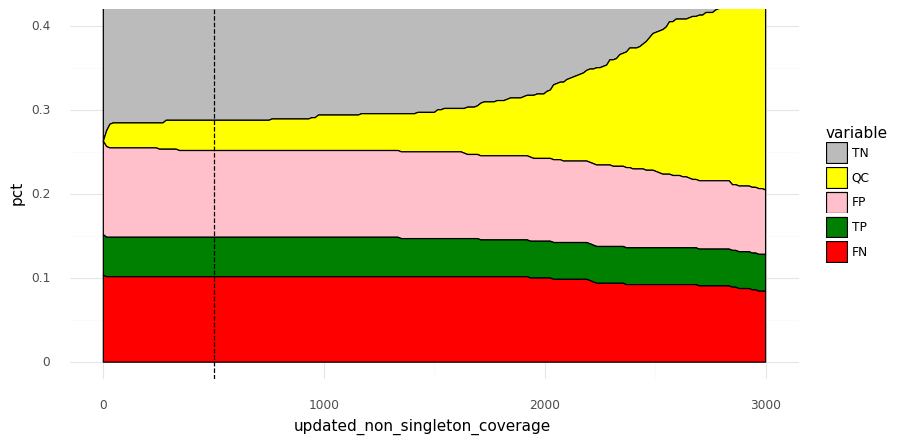

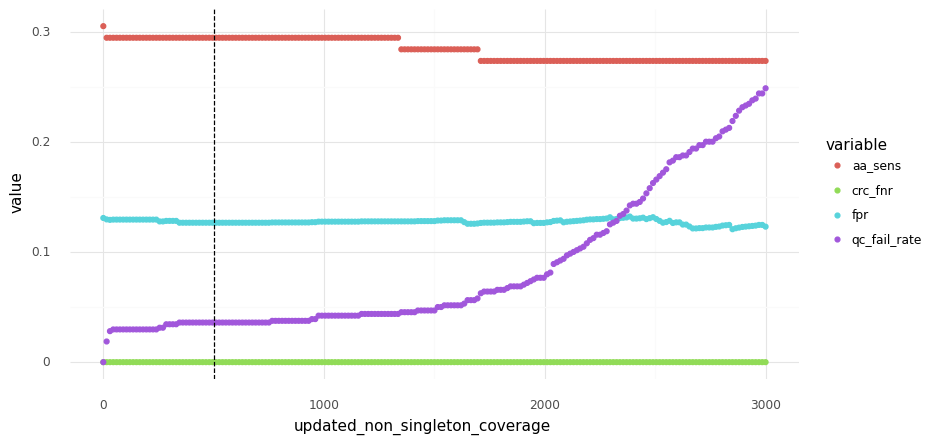

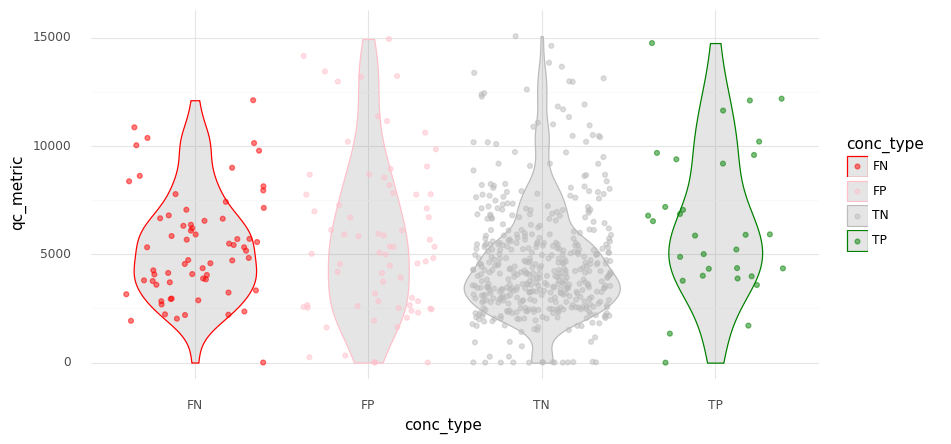

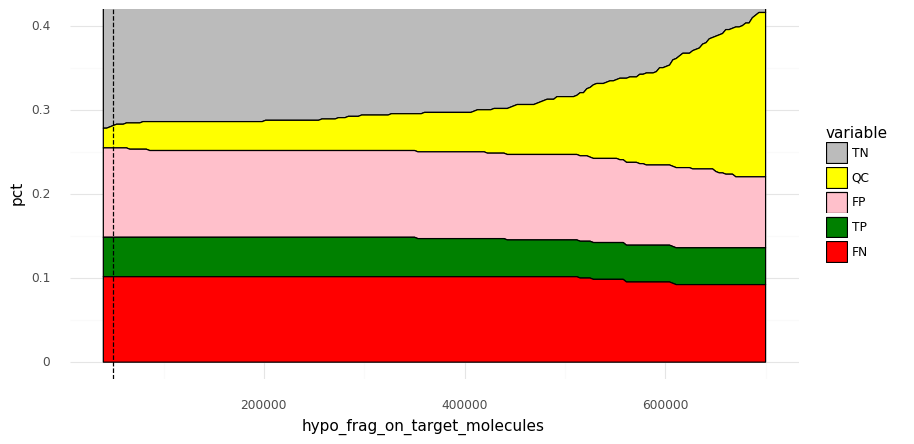

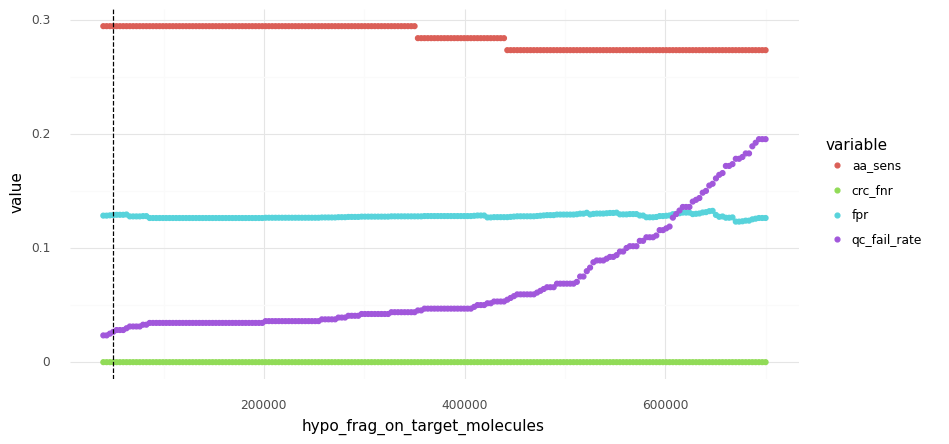

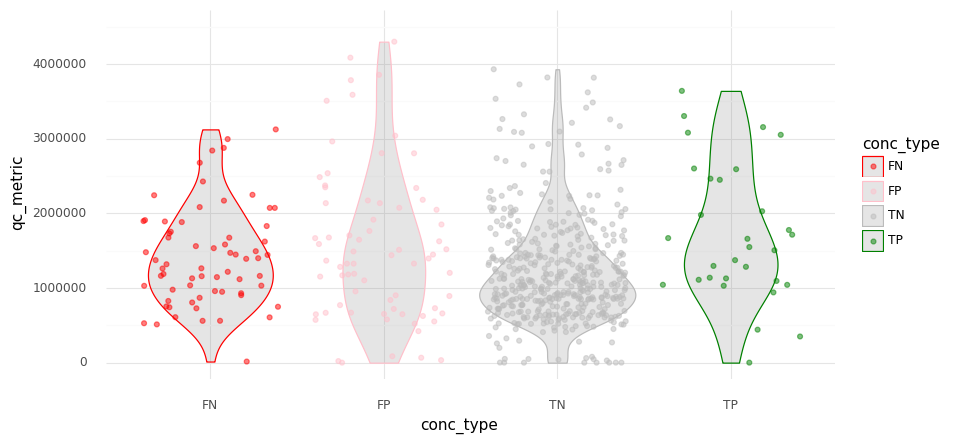

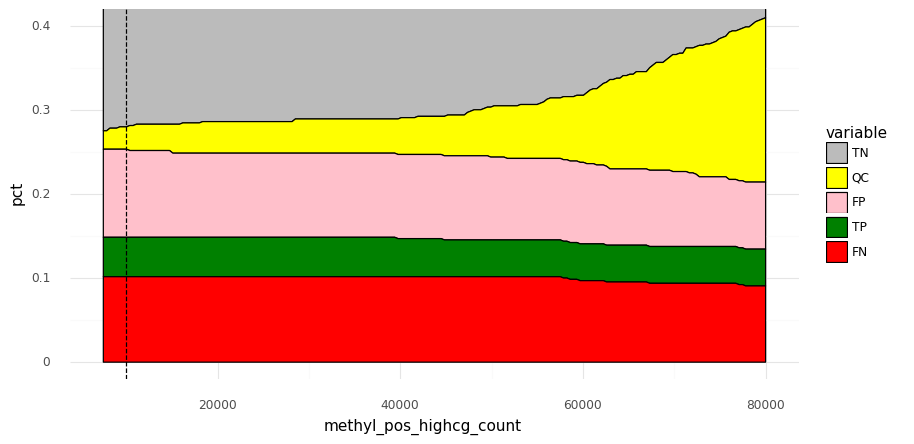

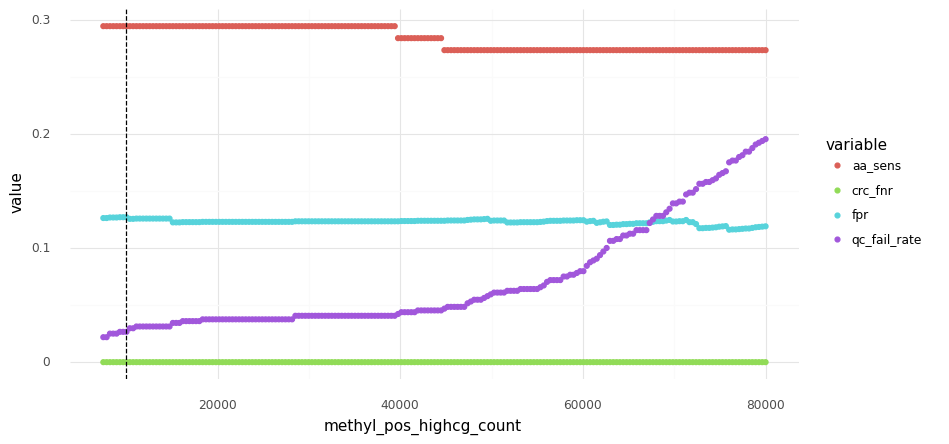

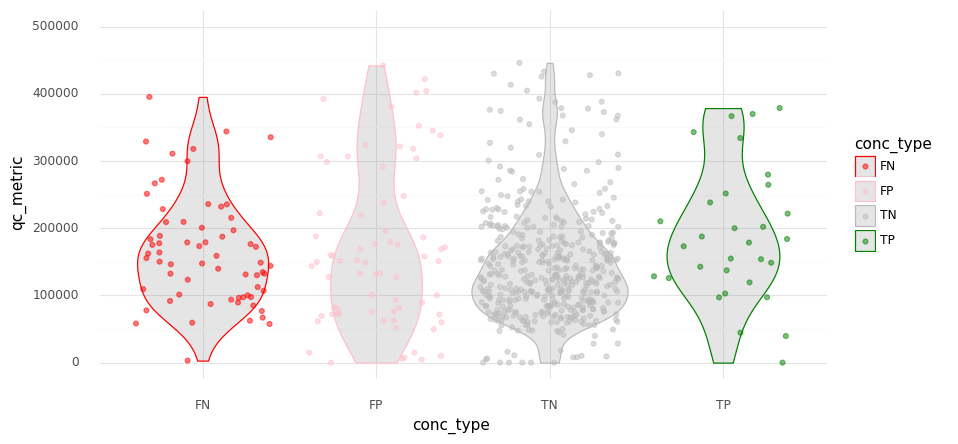

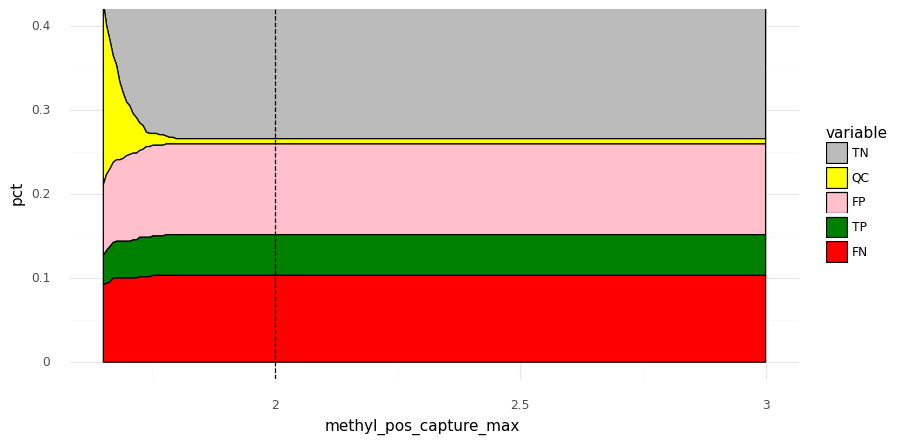

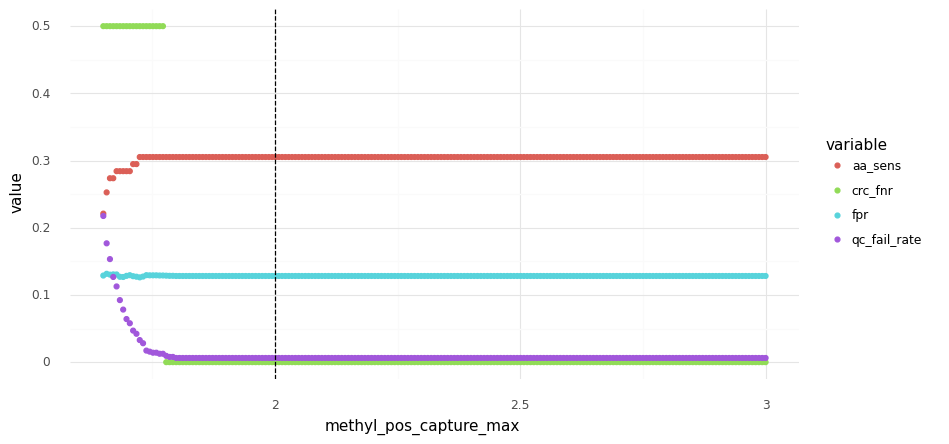

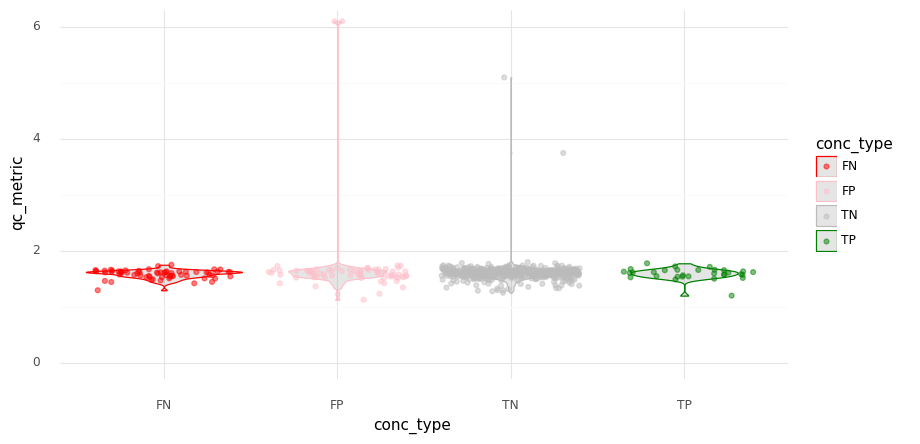

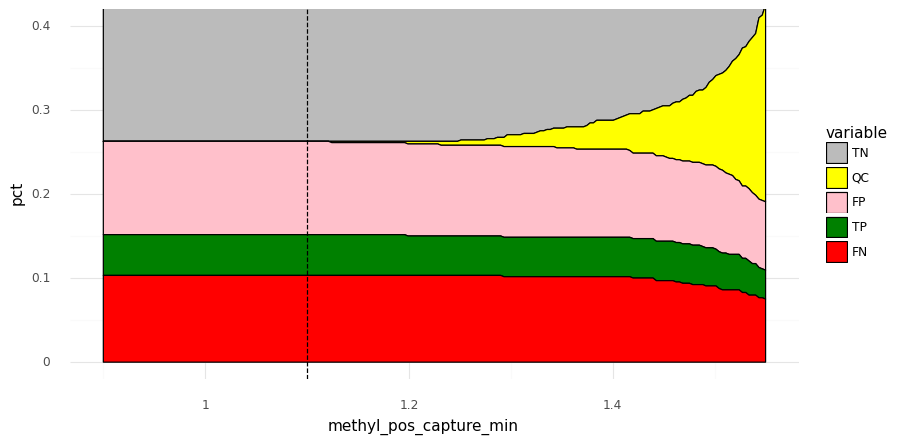

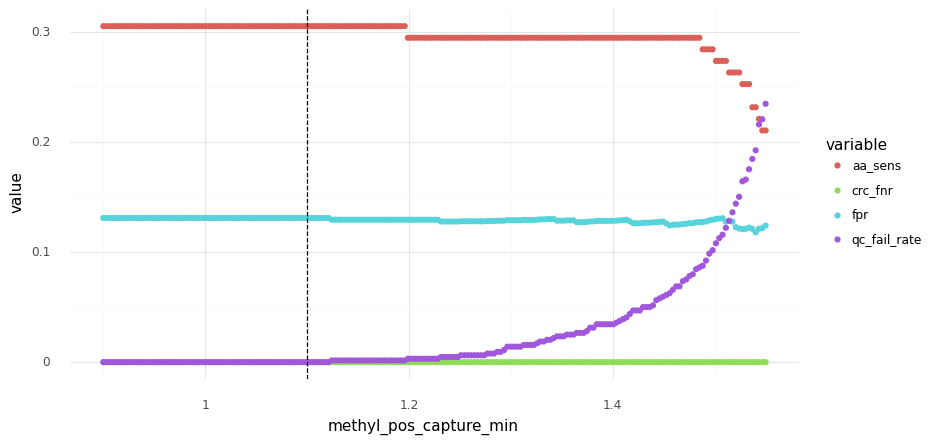

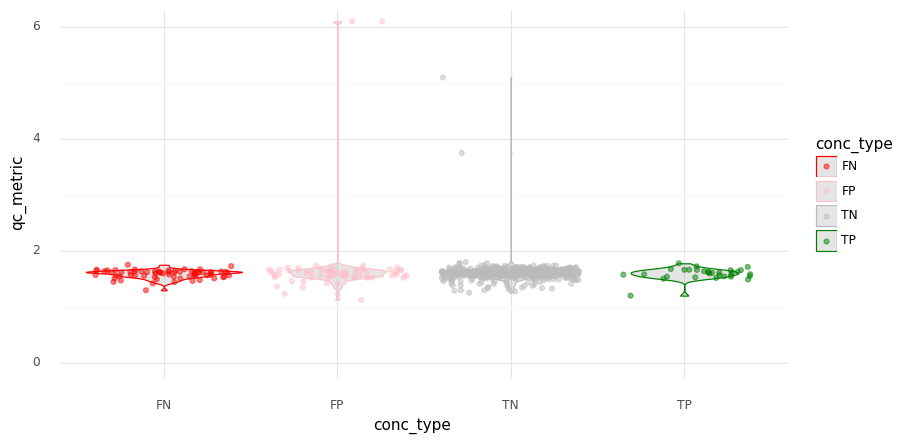

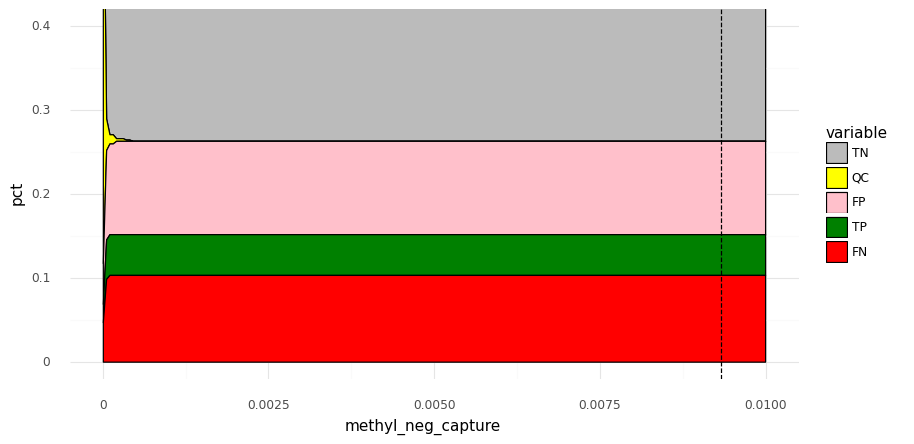

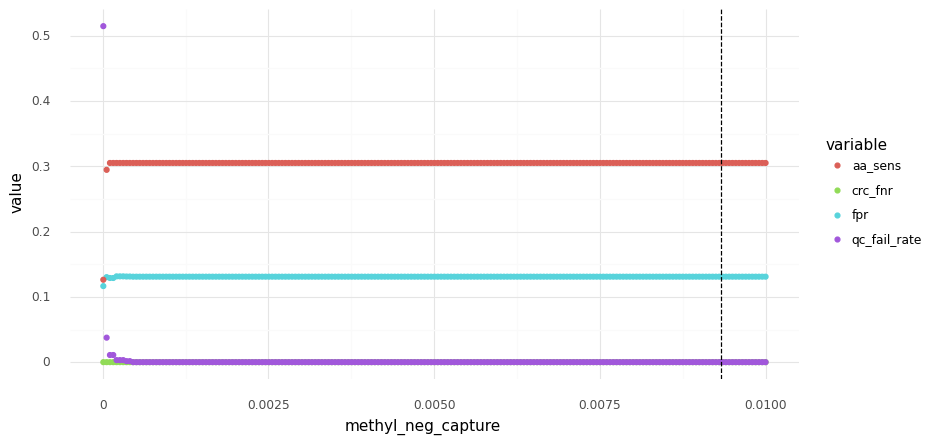

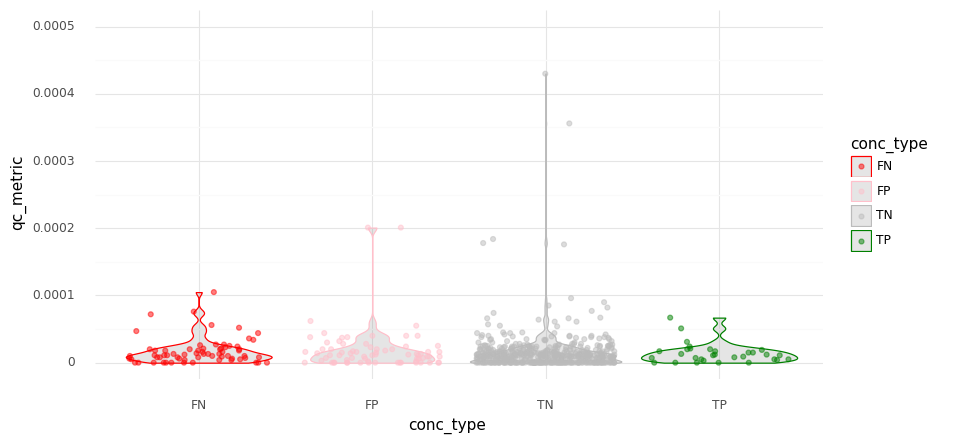

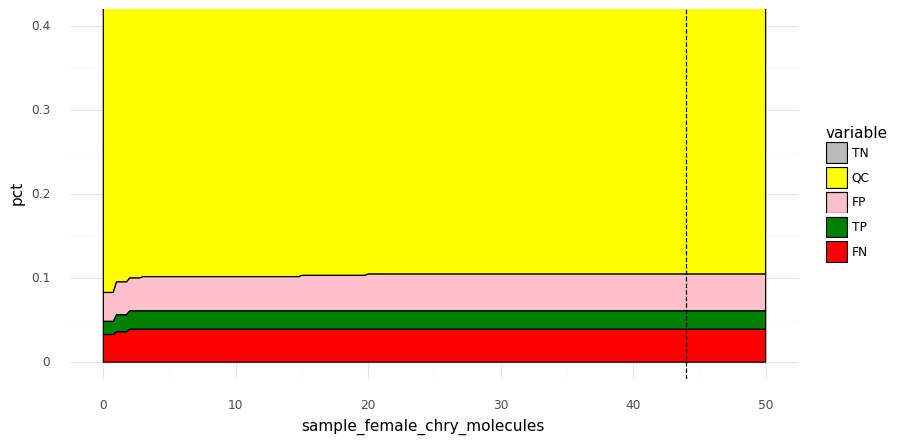

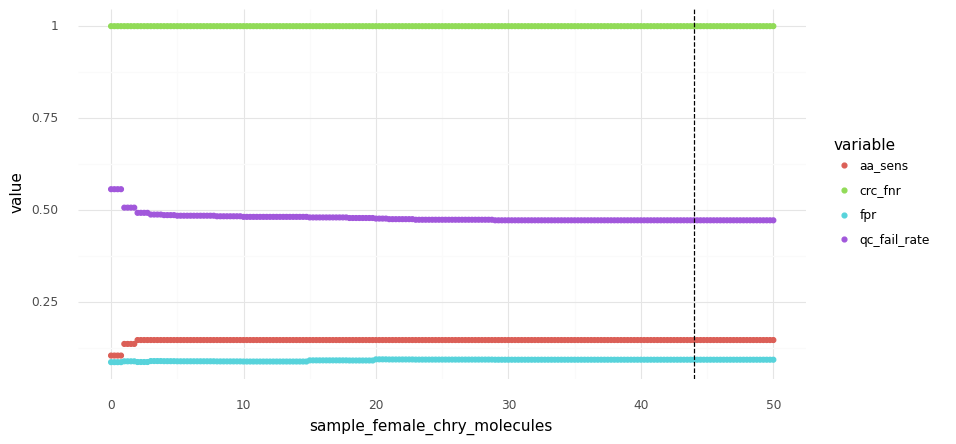

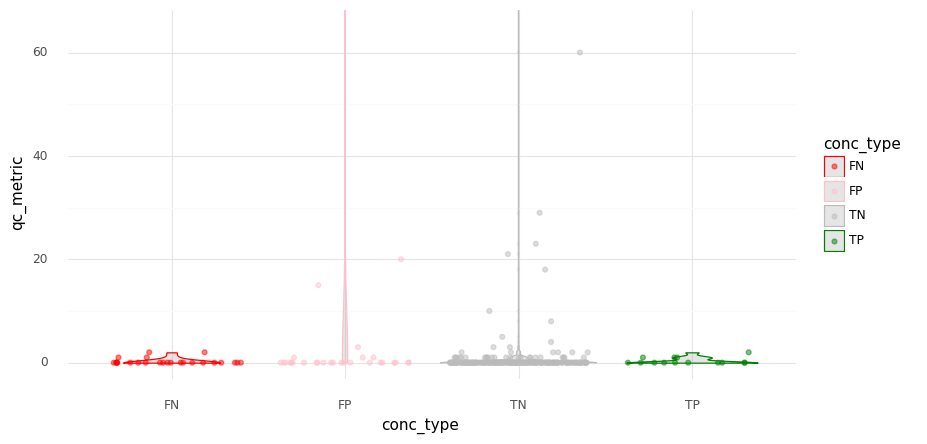

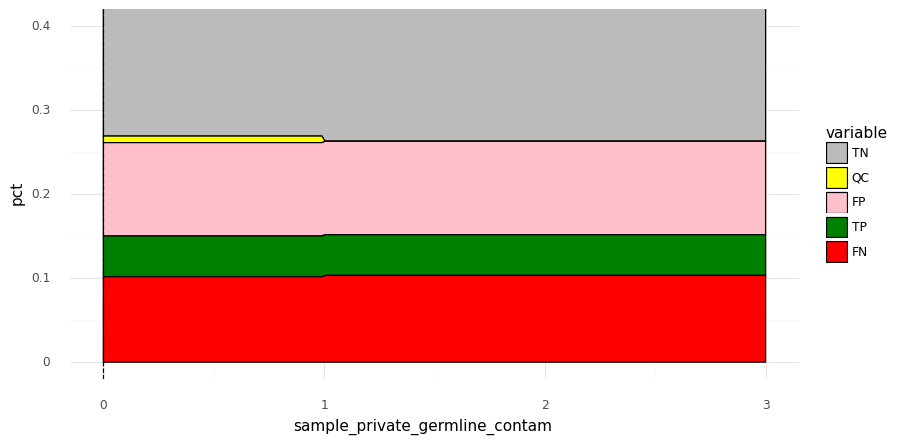

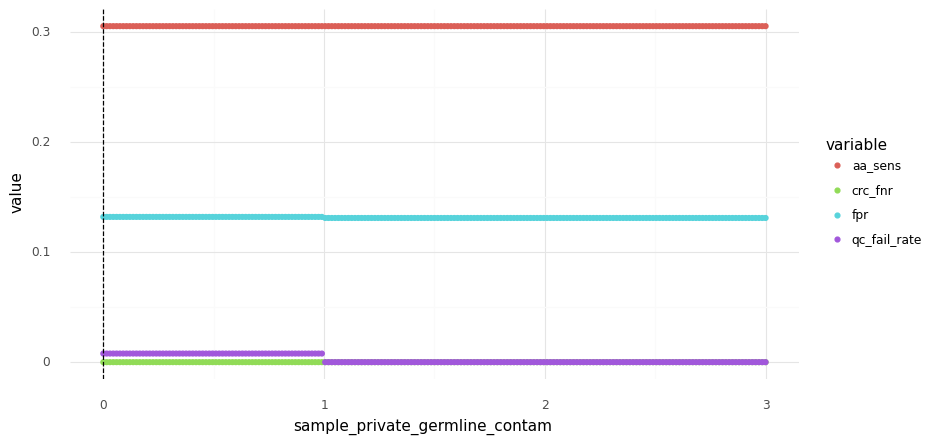

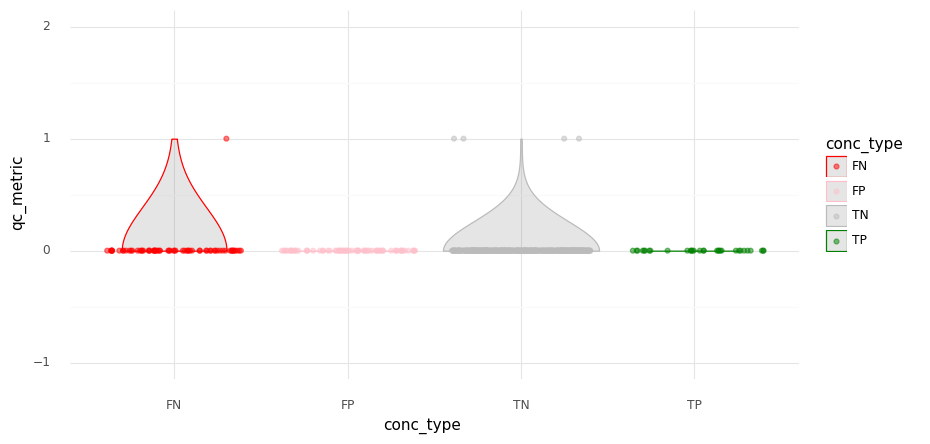

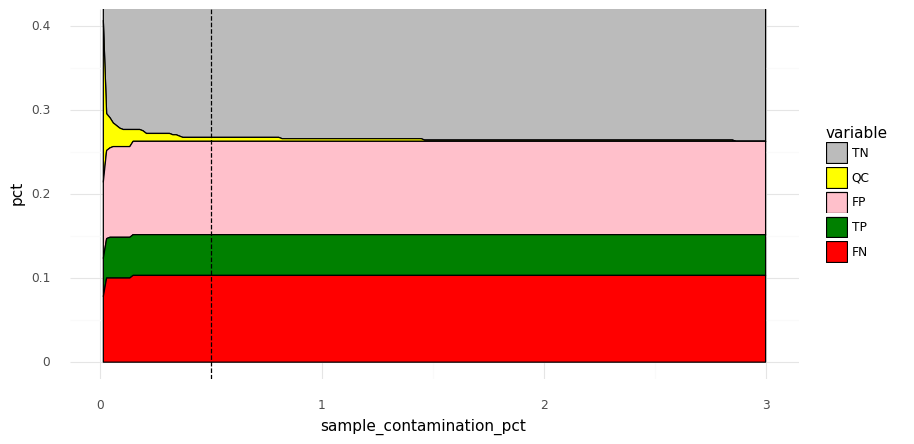

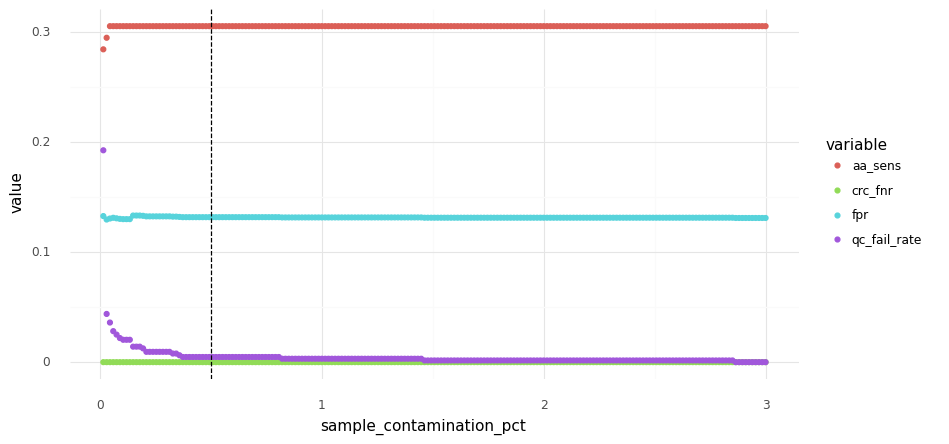

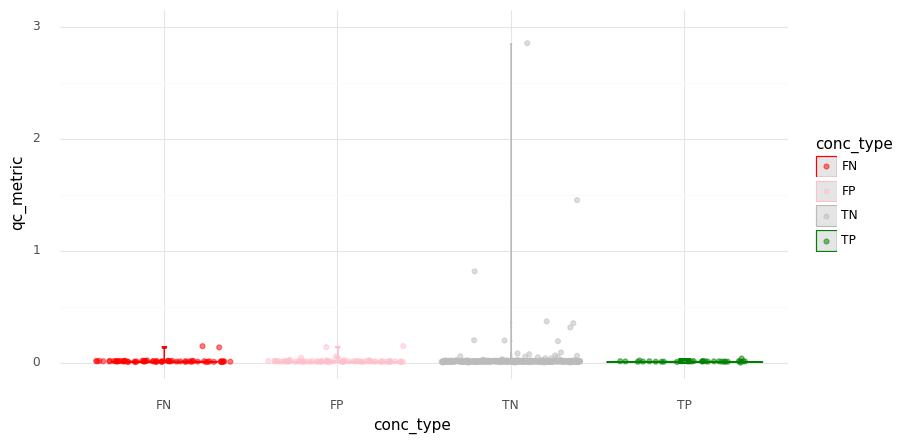

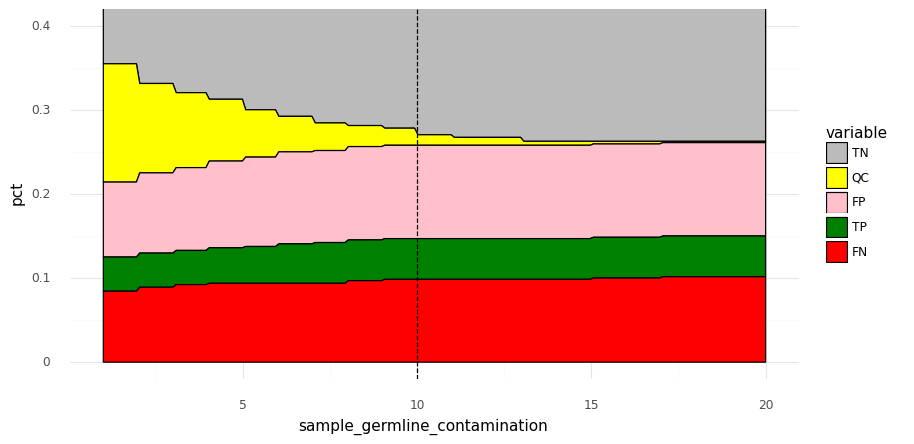

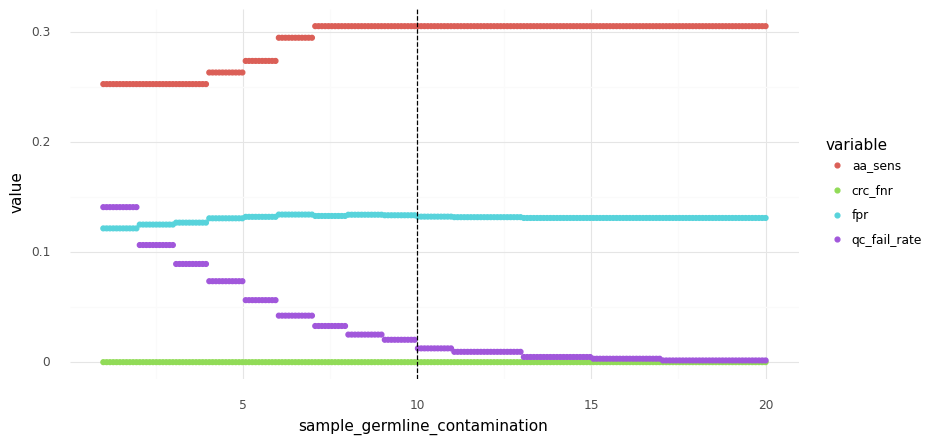

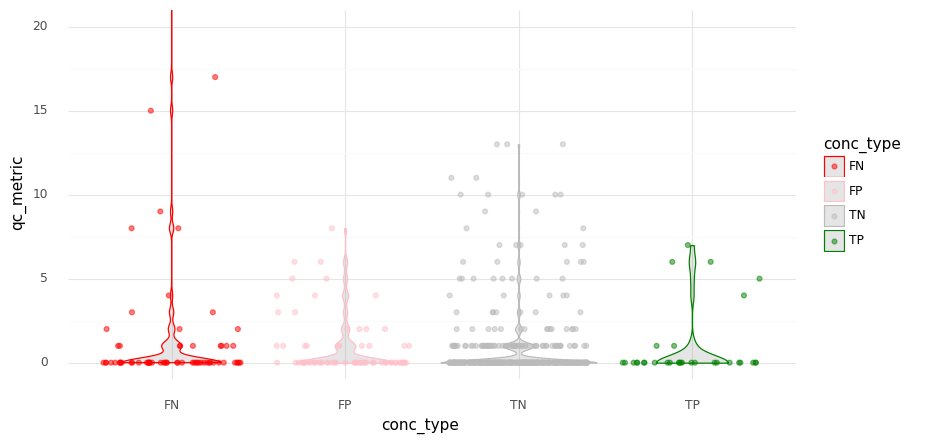

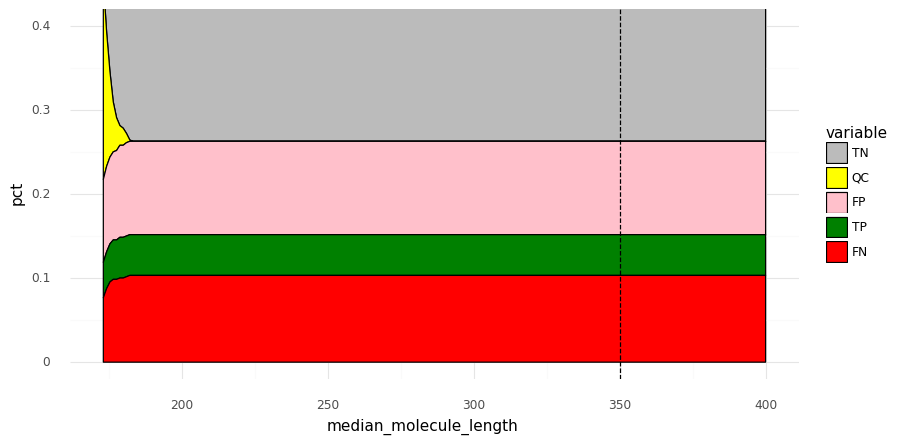

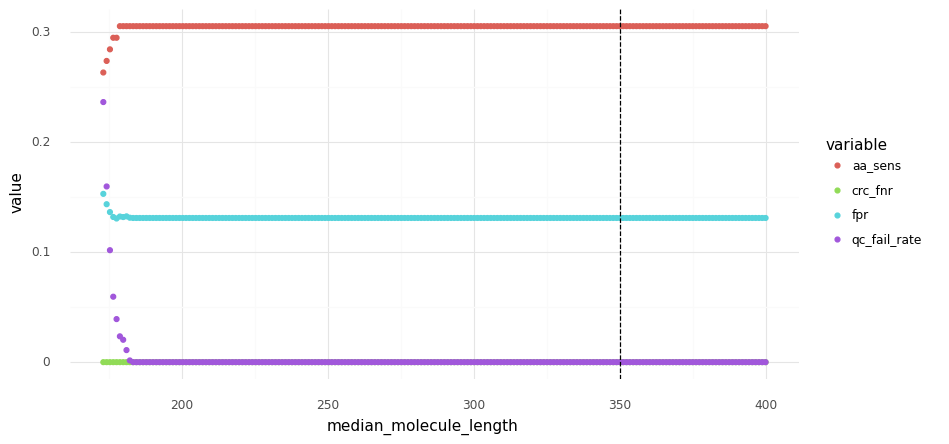

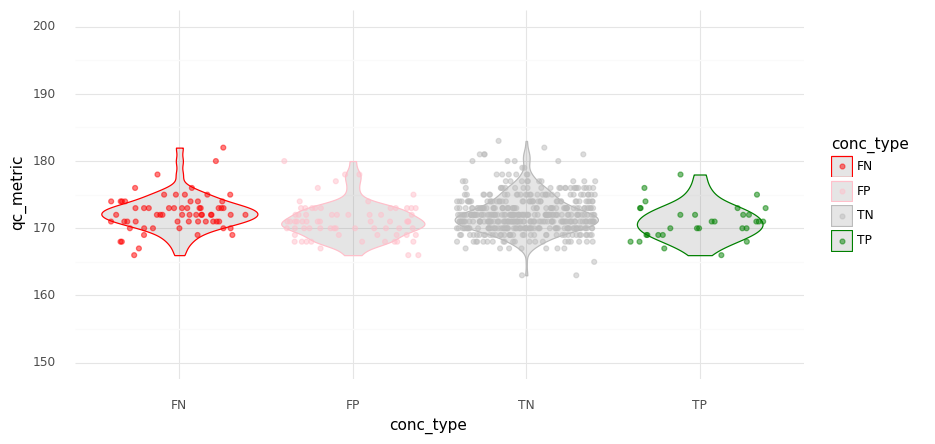

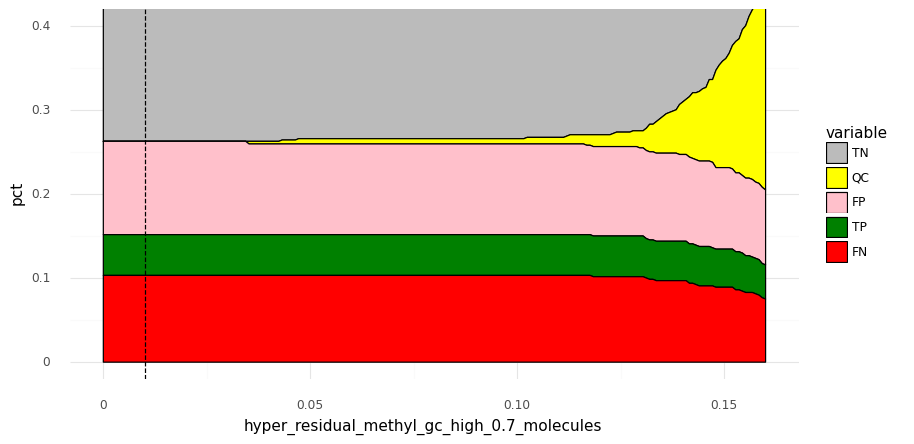

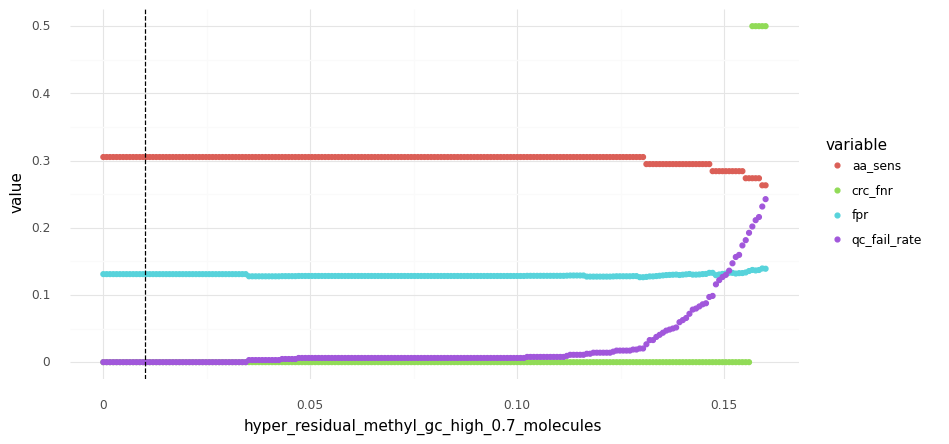

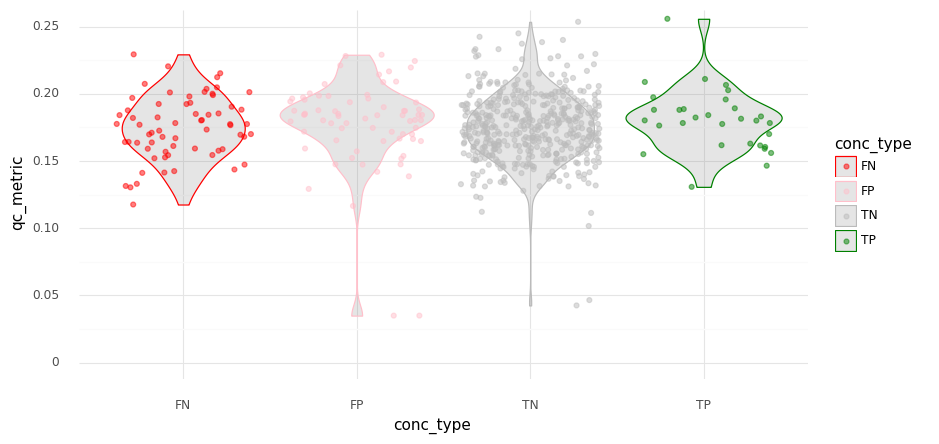

In [1219]:
qc_metric = 'hypo_frag_on_target_molecules'
for qc_metric in qc_metrics:
    metric_threshold, metric_lower, metric_upper, plot_lower, \
    plot_upper, operator = \
        qc_metrics[qc_metric]
    df_metric = sandbox2_data[[
        'run_id', 'cancer_type', 'ref_call', 
        qc_metric, 'cfdna_call', 'protein_call', 'final_call',
        'conc_type']].copy().\
        rename(columns={qc_metric: 'qc_metric'})
    df_thresholds = get_df_threshold(df_metric, metric_lower, metric_upper, operator)
    p_area = show_overview_chart(df_thresholds, metric_threshold) 
    p_performance = show_performance_chart(df_thresholds, metric_threshold)
    p_violins = show_qc_violins(df_metric, plot_lower, plot_upper)
    print(p_area)
    print(p_performance)
    print(p_violins)

hypo_frag_on_target_molecules
4299036


<Figure size 1728x720 with 0 Axes>

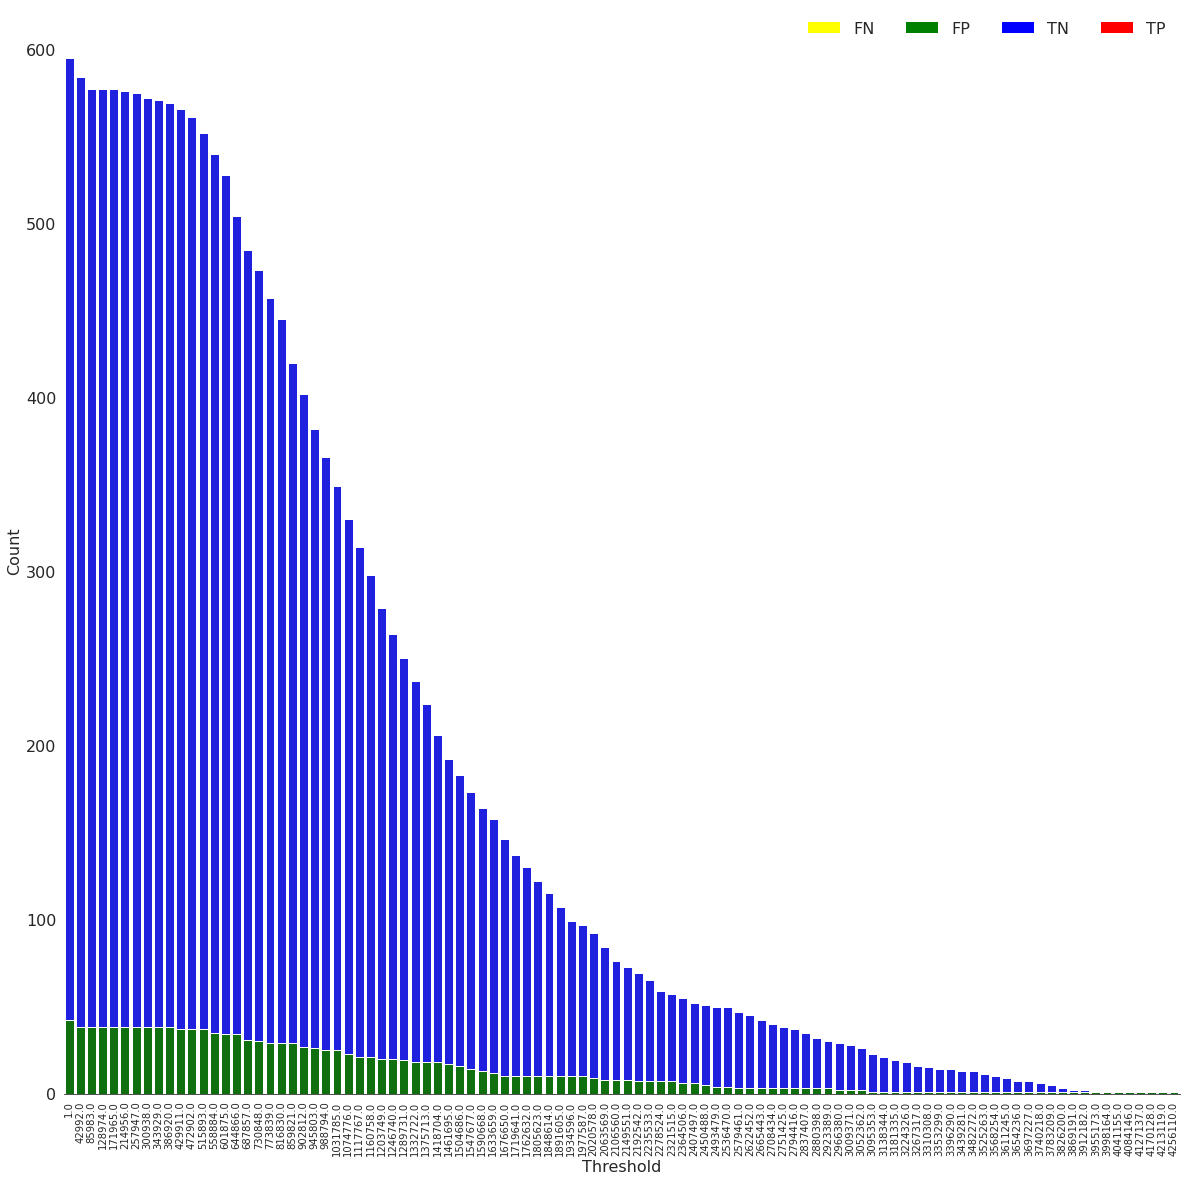

In [764]:
sandbox2_data = pd.merge(merge_patient_run_id_data, autoqc_df_wide_table, left_on=['run_id'], right_on=['run_sample_id'], how='inner', suffixes=('_y', ''))
sandbox2_data.to_csv('sandbox2_BIP4_data.tsv')

def sensitivity_plot(metrics, cutoff):
    print(metrics)
    max_metric=round(max(sandbox2_data[metrics]))
    print(max_metric)
    increment_metric = np.ceil(max_metric/100)
    
    sensitivity_plot=pd.DataFrame(columns=["Threshold","Pass_Ratio","Sensitivity","Specificity","TP","TN","FP","FN"])
    
    i=1
    while i < max_metric:
        selected_sandbox2_data=sandbox2_data[sandbox2_data[metrics]>i]
        pass_ratio = len(selected_sandbox2_data)/len(sandbox2_data)
        selected_sandbox2_data_tp=selected_sandbox2_data.loc[(selected_sandbox2_data['cancer_type'] == 'crc') & (selected_sandbox2_data['cfdna_int_call'] == 1)]
        selected_sandbox2_data_tn=selected_sandbox2_data.loc[(selected_sandbox2_data['cancer_type'] != 'crc') & (selected_sandbox2_data['cfdna_int_call'] == 0)]
        selected_sandbox2_data_fp=selected_sandbox2_data.loc[(selected_sandbox2_data['cancer_type'] != 'crc') & (selected_sandbox2_data['cfdna_int_call'] == 1)]
        selected_sandbox2_data_fn=selected_sandbox2_data.loc[(selected_sandbox2_data['cancer_type'] == 'crc') & (selected_sandbox2_data['cfdna_int_call'] == 0)]
        tp = len(selected_sandbox2_data_tp)
        tn = len(selected_sandbox2_data_tn)
        fp = len(selected_sandbox2_data_fp)
        fn = len(selected_sandbox2_data_fn)
        total = tp + tn + fp + fn
        if(tp+fn):
            sensitivity= tp/(tp+fn)
        else:
            sensitivity= None
        if(tn+fp):
            specificity= tn/(tn+fp)
        else:
            specificity= None
#        print("total:")
#        print(total)
#        print("tp:")
#        print(tp)
#        print("tn:")
#        print(tn)
#        print("fp:")
#        print(fp)
#        print("fn:")
#        print(fn)        
        sensitivity_plot.loc[i]= [i, pass_ratio, sensitivity, specificity, tp, tn, fp, fn]
        i = i + increment_metric

    fig = plt.figure()
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(20,20))

#    axes.set_title(metrics)
#    axes.axvline(cutoff, color='black', ls='--')
    #Set general plot properties
    sns.set_style("white")
    sns.set_context({"figure.figsize": (24, 10)})

    #Plot 1 - TP
    sns.barplot(x = sensitivity_plot.Threshold, y = sensitivity_plot.TP, color = "red")
    #Plot 2 - TN
    plot_2 = sns.barplot(x = sensitivity_plot.Threshold, y = sensitivity_plot.TN, color = "blue")
    #Plot 3 - FP
    plot_3 = sns.barplot(x = sensitivity_plot.Threshold, y = sensitivity_plot.FP, color = "green")
    #Plot 4 - FN
    plot_4 = sns.barplot(x = sensitivity_plot.Threshold, y = sensitivity_plot.FN, color = "yellow")


    topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
    bar_2 = plt.Rectangle((0,0),1,1,fc='blue',  edgecolor = 'none')
    bar_3 = plt.Rectangle((0,0),1,1,fc='green',  edgecolor = 'none')
    bar_4 = plt.Rectangle((0,0),1,1,fc='yellow',  edgecolor = 'none')
    l = plt.legend([bar_4, bar_3, bar_2, topbar], ['FN', 'FP', 'TN', 'TP'], loc=1, ncol = 4, prop={'size':16})
    l.draw_frame(False)

    #Optional code - Make plot look nicer
    sns.despine(left=True)
    plot_2.set_ylabel("Count")
    plot_2.set_xlabel("Threshold")

    #Set fonts to consistent 16pt size
    for item in ([plot_2.xaxis.label, plot_2.yaxis.label] +
                 plot_2.get_xticklabels() + plot_2.get_yticklabels()):
        item.set_fontsize(16)

    f = mtick.ScalarFormatter(useOffset=False, useMathText=True)
    g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
    plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(g))
    plot_4.set_xticklabels(plot_4.get_xticklabels(),rotation = 90, size = 10)
    
    file_name = '/home/galterovitz/working_miniconda3_env/sandbox2_QC/sensitivity_analysis/'+metrics+'_box.png' 
    plt.savefig(file_name)
#    plt.show()

sensitivity_plot("hypo_frag_on_target_molecules", 50000)
#sensitivity_plot("methyl_pos_highcg_count", 10000)
#sensitivity_plot("methyl_pos_capture_max", 2)
#sensitivity_plot("methyl_pos_capture_min", 1.1)
#sensitivity_plot("methyl_neg_capture", 0.00933) #issue
#sensitivity_plot("sample_female_chry_molecules", 44) #issue
#sensitivity_plot("sample_private_germline_contam", 0) #issue
#sensitivity_plot("sample_contamination_pct", 0.5)
#sensitivity_plot("sample_germline_contamination", 10)
#sensitivity_plot("median_molecule_length", 350)
#sensitivity_plot("gc_high_0.7_molecules", 0.01) # issue

hypo_frag_on_target_molecules
4299036


<Figure size 1728x720 with 0 Axes>

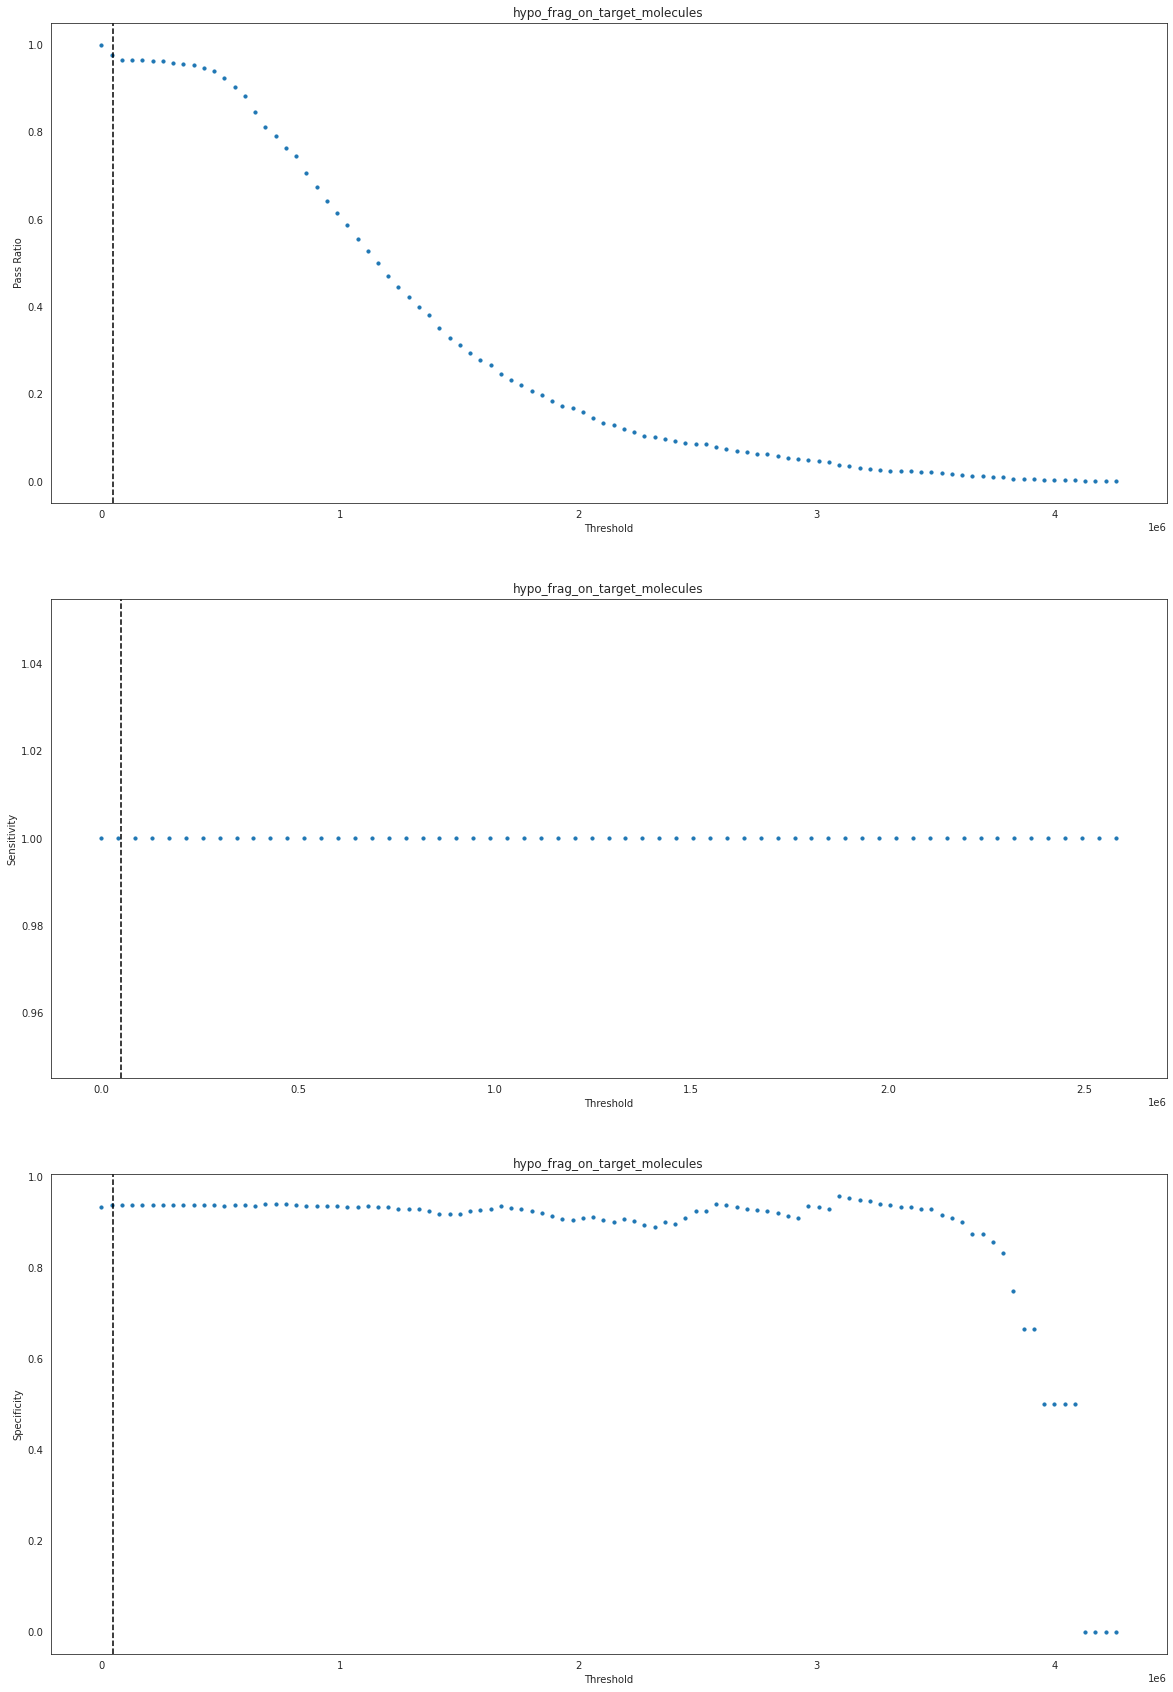

methyl_pos_highcg_count
446135


<Figure size 1728x720 with 0 Axes>

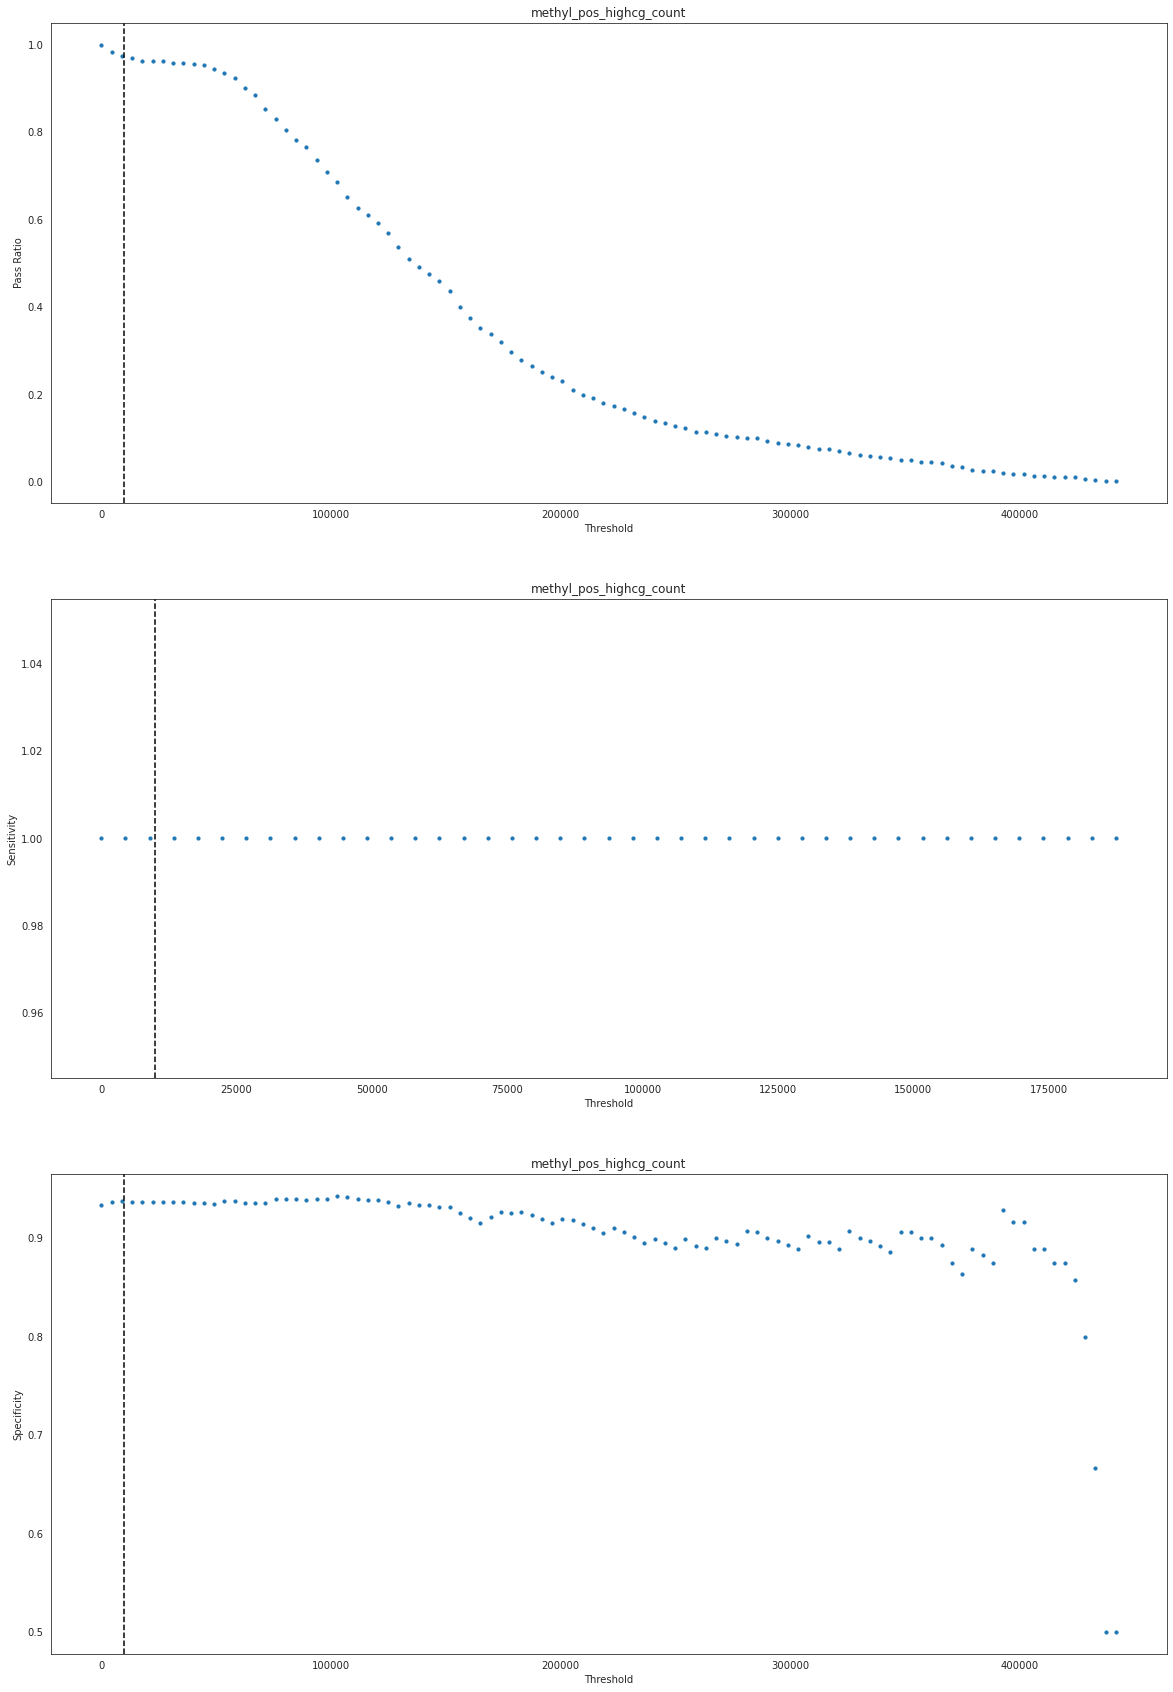

methyl_pos_capture_max
6


<Figure size 1728x720 with 0 Axes>

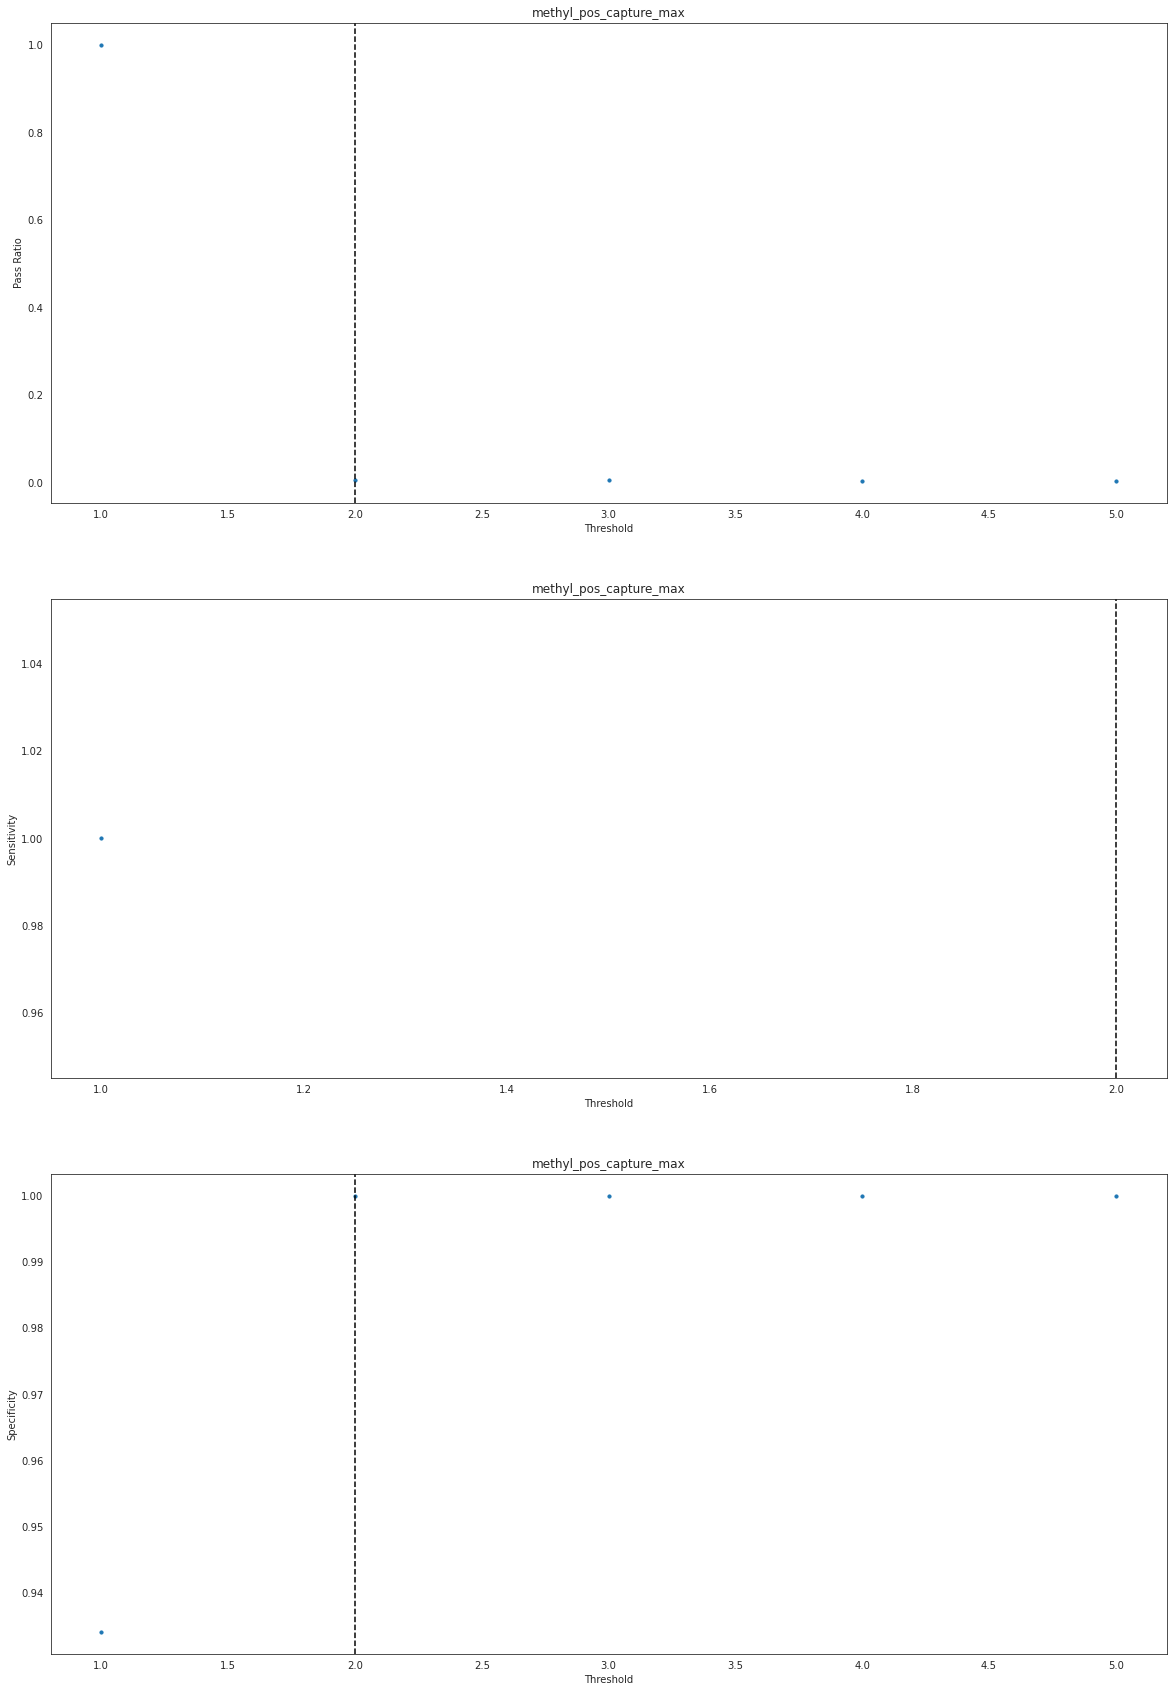

In [578]:
sandbox2_data = pd.merge(merge_patient_run_id_data, autoqc_df_wide_table, left_on=['run_id'], right_on=['run_sample_id'], how='inner', suffixes=('_y', ''))
sandbox2_data.to_csv('sandbox2_BIP4_data.tsv')


def sensitivity_plot(metrics, cutoff):
    print(metrics)
    max_metric=round(max(sandbox2_data[metrics]))
    print(max_metric)
    increment_metric = np.ceil(max_metric/100)
    
    sensitivity_plot=pd.DataFrame(columns=["Threshold","Pass_Ratio","Sensitivity","Specificity"])
    
    i=1
    while i < max_metric:
        selected_sandbox2_data=sandbox2_data[sandbox2_data[metrics]>i]
        pass_ratio = len(selected_sandbox2_data)/len(sandbox2_data)
        selected_sandbox2_data_tp=selected_sandbox2_data.loc[(selected_sandbox2_data['cancer_type'] == 'crc') & (selected_sandbox2_data['cfdna_int_call'] == 1)]
        selected_sandbox2_data_tn=selected_sandbox2_data.loc[(selected_sandbox2_data['cancer_type'] != 'crc') & (selected_sandbox2_data['cfdna_int_call'] == 0)]
        selected_sandbox2_data_fp=selected_sandbox2_data.loc[(selected_sandbox2_data['cancer_type'] != 'crc') & (selected_sandbox2_data['cfdna_int_call'] == 1)]
        selected_sandbox2_data_fn=selected_sandbox2_data.loc[(selected_sandbox2_data['cancer_type'] == 'crc') & (selected_sandbox2_data['cfdna_int_call'] == 0)]
        tp = len(selected_sandbox2_data_tp)
        tn = len(selected_sandbox2_data_tn)
        fp = len(selected_sandbox2_data_fp)
        fn = len(selected_sandbox2_data_fn)
        total = tp + tn + fp + fn
        if(tp+fn):
            sensitivity= tp/(tp+fn)
        else:
            sensitivity= None
        if(tn+fp):
            specificity= tn/(tn+fp)
        else:
            specificity= None
#        print("total:")
#        print(total)
#        print("tp:")
#        print(tp)
#        print("tp+fn:")
#        print(tp+fn)
        
        sensitivity_plot.loc[i]= [i, pass_ratio, sensitivity, specificity]
        i = i + increment_metric

    fig = plt.figure()
    fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize=(20,30))

    axes[0].scatter(sensitivity_plot.Threshold, sensitivity_plot.Pass_Ratio, s=10)
    axes[0].set_xlabel("Threshold")
    axes[0].set_ylabel("Pass Ratio") 
    axes[0].set_title(metrics)
    axes[0].axvline(cutoff, color='black', ls='--')
    
    axes[1].scatter(sensitivity_plot.Threshold, sensitivity_plot.Sensitivity, s=10)
    axes[1].set_xlabel("Threshold")
    axes[1].set_ylabel("Sensitivity") 
    axes[1].set_title(metrics)
    axes[1].axvline(cutoff, color='black', ls='--')
    
    axes[2].scatter(sensitivity_plot.Threshold, sensitivity_plot.Specificity, s=10)
    axes[2].set_xlabel("Threshold")
    axes[2].set_ylabel("Specificity") 
    axes[2].set_title(metrics)
    axes[2].axvline(cutoff, color='black', ls='--')

    file_name = '/home/galterovitz/working_miniconda3_env/sandbox2_QC/sensitivity_analysis/'+metrics+'.png' 
    plt.savefig(file_name)
    plt.show()

sensitivity_plot("hypo_frag_on_target_molecules", 50000)
sensitivity_plot("methyl_pos_highcg_count", 10000)
sensitivity_plot("methyl_pos_capture_max", 2)
#sensitivity_plot("methyl_pos_capture_min", 1.1)
#sensitivity_plot("methyl_neg_capture", 0.00933) #issue
#sensitivity_plot("sample_female_chry_molecules", 44) #issue
#sensitivity_plot("sample_private_germline_contam", 0) #issue
#sensitivity_plot("sample_contamination_pct", 0.5)
#sensitivity_plot("sample_germline_contamination", 10)
#sensitivity_plot("median_molecule_length", 350)
#sensitivity_plot("gc_high_0.7_molecules", 0.01) # issue